In [1]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

import copy

In [2]:
from utils_model_sampling import sample_models_across_time
from utils import load_models

In [3]:
# 7/2/21: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
# end cite

## Note: running on unigram scores that may not be fully correct -- will correct when OM is back up.

In [4]:

raw_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order())

# Remove 0.5 and 4.0 because they are sparse.
raw_scores_across_time = raw_scores_across_time[~raw_scores_across_time.age.isin({0.5, 4.0})]

/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_1.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_4.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_2.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_0.5.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/r

/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/old/CHILDES_BERT_without_tags,_older_children,_same_utt_only/run_models_across_time_1.5.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/old/CHILDES_BERT_without_tags,_older_children,_same_utt_only/run_models_across_time_3.5.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/old/CHILDES_BERT_without_tags,_older_children,_same_utt_only/run_models_across_time_3.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/old/CHILDES_BERT_without_tags,_older_children,_+-20_utts_context/run_models_across_time_1.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning

In [5]:
# Possibly too complex to generate the betas in the title automatically
# -- for now, just display the betas in the notebook separately.

from utils_model_sampling import beta_utils
from pprint import pprint

all_args = load_models.gen_all_model_args()

beta_set = {}
for arg_set in all_args:
    model_title = load_models.gen_model_title(*arg_set)
    this_beta = beta_utils.get_optimal_beta_value(*arg_set)
    
    beta_set[model_title] = round(this_beta, 3)
    
pprint(beta_set)

{'Adult BERT without tags, , +-20 utts context': 3.3,
 'Adult BERT without tags, , same utt only': 3.4,
 'CHILDES BERT with tags, , +-20 utts context': 3.0,
 'CHILDES BERT with tags, , same utt only': 3.1,
 'CHILDES BERT with tags, older children, +-20 utts context': 3.4,
 'CHILDES BERT with tags, older children, same utt only': 3.4,
 'CHILDES BERT with tags, younger children, +-20 utts context': 3.0,
 'CHILDES BERT with tags, younger children, same utt only': 3.1,
 'CHILDES BERT without tags, , +-20 utts context': 3.0,
 'CHILDES BERT without tags, , same utt only': 3.2,
 'CHILDES BERT without tags, older children, +-20 utts context': 3.4,
 'CHILDES BERT without tags, older children, same utt only': 3.4,
 'CHILDES BERT without tags, younger children, +-20 utts context': 3.1,
 'CHILDES BERT without tags, younger children, same utt only': 3.1,
 'CHILDES unigram without tags, , same utt only': 2.5,
 'Flat prior without tags, , same utt only': 2.5}


In [53]:
# From the original analysis

original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram', 
}


tags_context_only = {
    "CHILDES BERT with tags, , +-20 utts context",
    'CHILDES BERT with tags, older children, +-20 utts context',
    'CHILDES BERT with tags, younger children, +-20 utts context',
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, older children, +-20 utts context',
    'CHILDES BERT without tags, younger children, +-20 utts context',
    #'Flat Unigram',
}

merge_orig_tags = copy.deepcopy(tags_context_only)
merge_orig_tags.update(original_set_of_models)

#scores_across_time = raw_scores_across_time.copy()
scores_across_time = raw_scores_across_time[raw_scores_across_time.model.isin(tags_context_only)].copy()


In [54]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

In [55]:
%%R
library('plyr')
# rename the models

# Do this manually for now.

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')


# 10 Average Prior Surprisal

In [56]:
%%R
names(successes_across_time)

aggregate(prior_surprisal ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})

                     model prior_surprisal
1         CDL+Context+Tags        3.329245
2              CDL+Context        3.438884
3   CDL+Older+Context+Tags        3.419213
4        CDL+Older+Context        3.531681
5 CDL+Younger+Context+Tags        3.488076
6      CDL+Younger+Context        3.514808


In [57]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_surprisal',
'bert_token_id')], model, prior_surprisal)

head(successes_across_time_wide)

  bert_token_id CDL+Context+Tags  CDL+Context CDL+Older+Context+Tags
1         49676     0.0009260167 0.0007204352           0.0004065618
2         52857     0.0110804634 0.0256987140           0.0046467707
3         60498     0.0001718302 0.0025232614           0.0134188002
4         60499     0.0005986911 0.0008698311           0.0002857940
5         65634     0.1349055618 0.1811656952           0.2467705309
6         65852     0.0875518247 0.0445239507           0.0570895337
  CDL+Older+Context CDL+Younger+Context+Tags CDL+Younger+Context
1      1.806228e-04             5.754528e-04        2.959278e-04
2      1.144458e-02             4.762041e-03        2.059814e-02
3      3.004536e-03             1.845791e-04        4.658899e-04
4      2.468799e-05             6.473048e-05        5.385762e-05
5      2.004428e-01             1.182221e-01        9.350581e-02
6      2.411982e-02             8.565550e-02        1.325952e-02


In [58]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

R[write to console]: Error in .subset2(x, i, exact = exact) : subscript out of bounds

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 7. Consider
specifying shapes manually if you must have them. 

R[write to console]: 2: Removed 6 rows containing missing values (geom_point). 

R[write to console]: 3: The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 7. Consider
specifying shapes manually if you must have them. 

R[write to console]: 4: Removed 6 rows containing missing values (geom_point). 




Error in .subset2(x, i, exact = exact) : subscript out of bounds


### Posterior Surprisal Across Ages

In [59]:
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

   age                    model posterior_surprisal_mean
1  1.5              CDL+Context                1.7674212
2  1.5         CDL+Context+Tags                1.7191905
3  1.5        CDL+Older+Context                1.8759416
4  1.5   CDL+Older+Context+Tags                1.8512236
5  1.5      CDL+Younger+Context                1.7596790
6  1.5 CDL+Younger+Context+Tags                1.7148751
7  1.0              CDL+Context                2.2549921
8  1.0         CDL+Context+Tags                2.2939770
9  1.0        CDL+Older+Context                2.6772680
10 1.0   CDL+Older+Context+Tags                2.6716646
11 1.0      CDL+Younger+Context                2.1648153
12 1.0 CDL+Younger+Context+Tags                2.1671858
13 2.5              CDL+Context                1.2450077
14 2.5         CDL+Context+Tags                1.2082614
15 2.5        CDL+Older+Context                1.2417270
16 2.5   CDL+Older+Context+Tags                1.2538290
17 2.5      CDL+Younger+Context

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,1.5,CDL+Context,1.767421,0.125771
2,1.5,CDL+Context+Tags,1.719191,0.123495
3,1.5,CDL+Older+Context,1.875942,0.134646
4,1.5,CDL+Older+Context+Tags,1.851224,0.131000
5,1.5,CDL+Younger+Context,1.759679,0.127753
6,1.5,CDL+Younger+Context+Tags,1.714875,0.122741
7,1.0,CDL+Context,2.254992,0.145398
8,1.0,CDL+Context+Tags,2.293977,0.146153
9,1.0,CDL+Older+Context,2.677268,0.160648
10,1.0,CDL+Older+Context+Tags,2.671665,0.161175


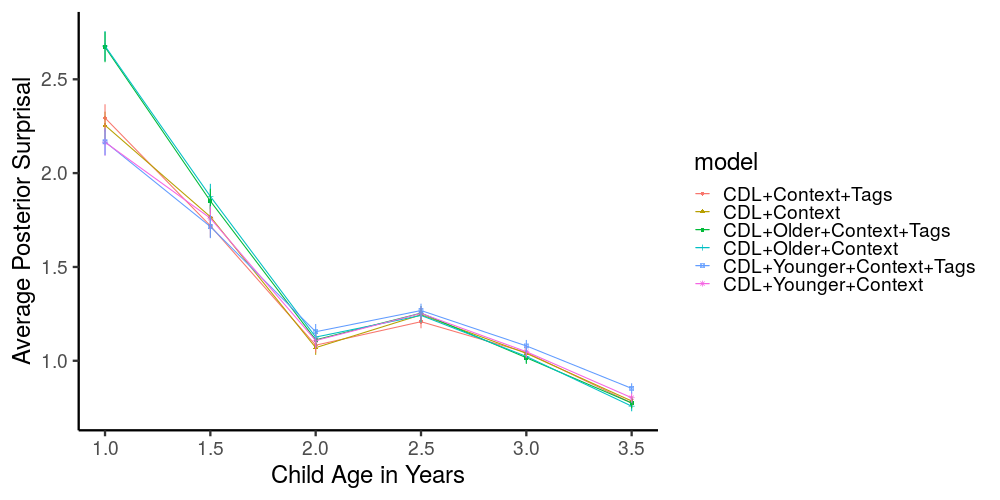

In [60]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

### Prior Surprisal Across Ages

In [61]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,1.5,CDL+Context,3.846919,0.161299
2,1.5,CDL+Context+Tags,3.626939,0.156541
3,1.5,CDL+Older+Context,4.055461,0.168421
4,1.5,CDL+Older+Context+Tags,3.852958,0.158088
5,1.5,CDL+Younger+Context,3.902104,0.166085
6,1.5,CDL+Younger+Context+Tags,3.713111,0.157624
7,1.0,CDL+Context,4.039141,0.181474
8,1.0,CDL+Context+Tags,3.961876,0.182636
9,1.0,CDL+Older+Context,4.545976,0.193624
10,1.0,CDL+Older+Context+Tags,4.378456,0.188325


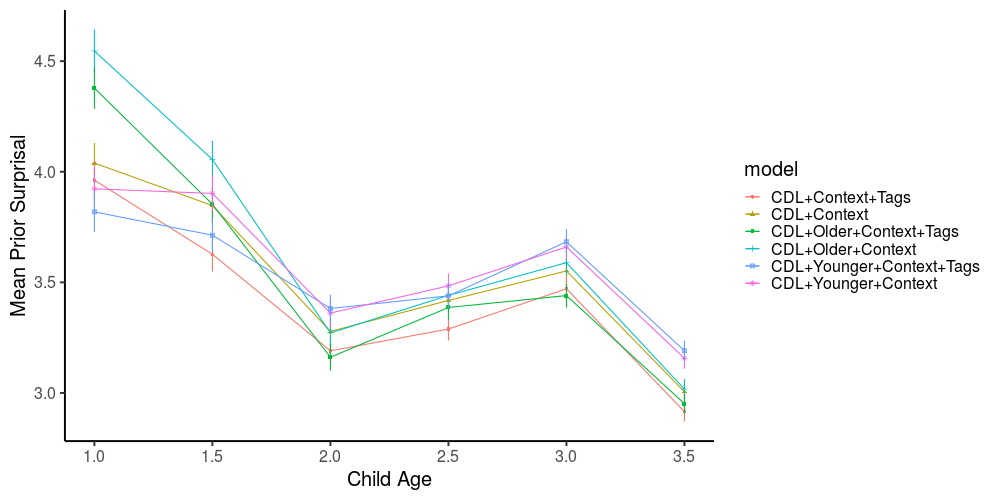

In [62]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model),
) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model, shape=model)) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [16]:
scores_across_time_short.set.value_counts()

success    116800
failure     41360
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [17]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,1.5,BERT+Context,failure,2.616747,0.054426
2,1.5,BERT+Context,success,1.194338,0.043794
3,1.5,BERT+OneUtt,failure,2.674961,0.056260
4,1.5,BERT+OneUtt,success,1.751668,0.046458
5,1.5,CDL+Context,failure,2.524947,0.056546
...,...,...,...,...,...
188,3.0,CDL+Younger+OneUtt+Tags,success,0.969471,0.029920
189,3.0,CHILDES 1gram,failure,3.929603,0.035483
190,3.0,CHILDES 1gram,success,3.646235,0.023150
191,3.0,UniformPrior,failure,6.124609,0.030457


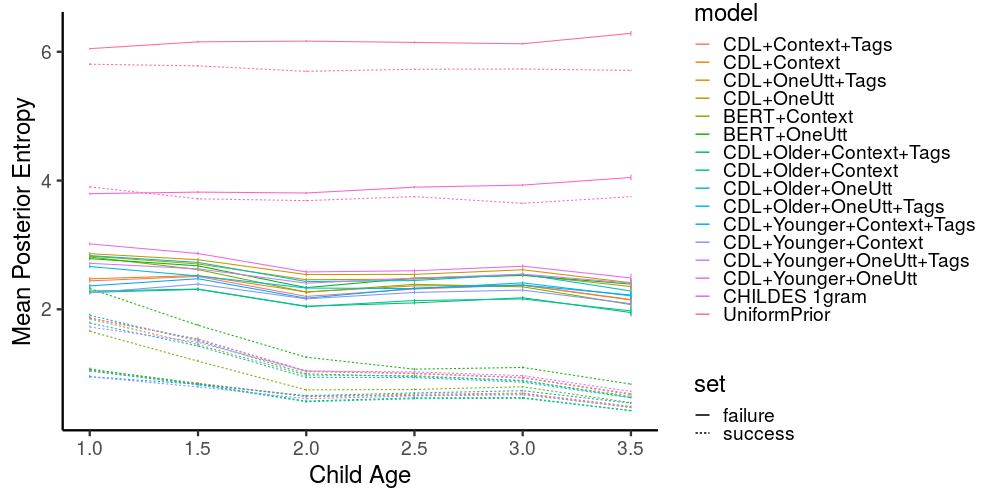

In [21]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [22]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [23]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age                  model     gain  gain_sem comparison age_in_months
1 1.5           BERT+Context 19.87164 0.2232269  posterior            18
2 1.5            BERT+OneUtt 17.49601 0.2018063  posterior            18
3 1.5            CDL+Context 21.73064 0.2142495  posterior            18
4 1.5       CDL+Context+Tags 21.90305 0.2097652  posterior            18
5 1.5      CDL+Older+Context 23.41241 0.2273929  posterior            18
6 1.5 CDL+Older+Context+Tags 23.34886 0.2246166  posterior            18


In [24]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

   age        model     gain   gain_sem comparison age_in_months
16 1.5 UniformPrior 5.584792 0.03672279  posterior            18
32 1.0 UniformPrior 5.390278 0.03803818  posterior            12
48 2.5 UniformPrior 5.767324 0.02815050  posterior            30
64 2.0 UniformPrior 5.686460 0.03116785  posterior            24
80 3.5 UniformPrior 5.746066 0.02624322  posterior            42
96 3.0 UniformPrior 5.774997 0.03031776  posterior            36


In [25]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

In [26]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

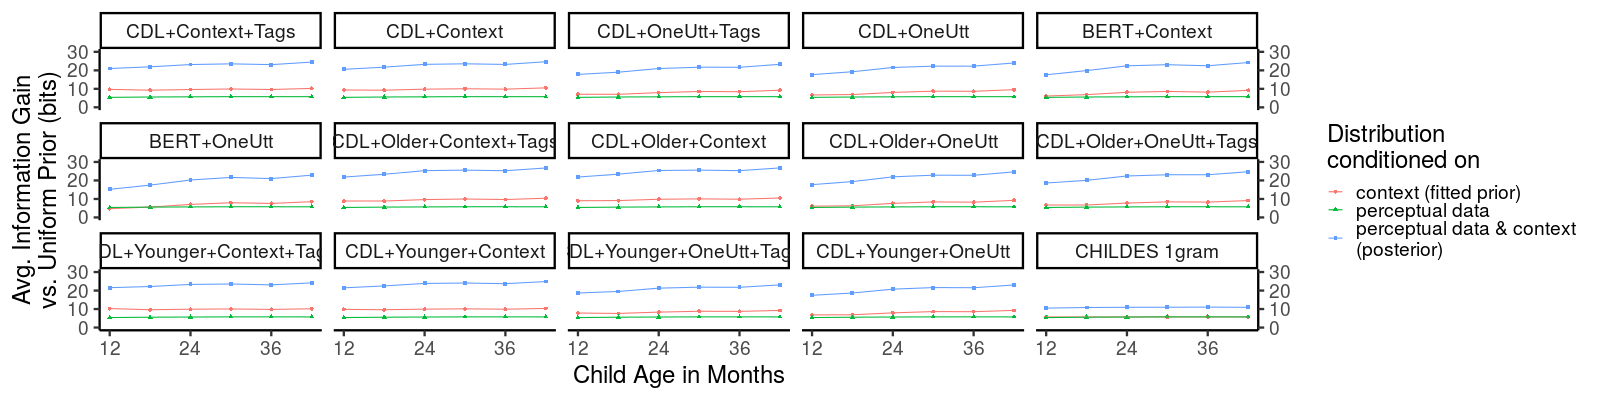

In [27]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

# 12 Posterior Probability as a function of edit distance

In [28]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

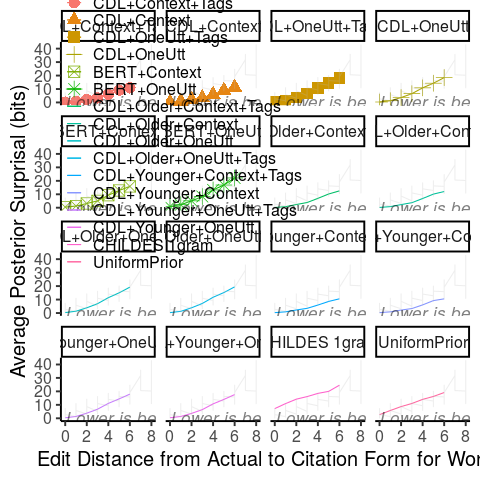

In [29]:
%%R
surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)


ref_dfs = do.call('rbind', lapply(unique(surprisal_by_edit_distance$model), function(model){ get_ref_df(model, surprisal_by_edit_distance)}))     


p1= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
facet_wrap(~model) + geom_line(data=ref_dfs, aes(x=edit_distance,y=mean_posterior_surprisal),colour='gray', alpha=.25)

ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [30]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


   edit_distance                  model mean_posterior_surprisal
1              0           BERT+Context                0.4434780
2              0            BERT+OneUtt                0.9349364
3              0            CDL+Context                0.2622400
4              0       CDL+Context+Tags                0.2358763
5              0      CDL+Older+Context                0.2103083
6              0 CDL+Older+Context+Tags                0.1933969
7              0       CDL+Older+OneUtt                0.3348398
8              0  CDL+Older+OneUtt+Tags                0.2940088
9              0             CDL+OneUtt                0.3436255
10             0        CDL+OneUtt+Tags                0.3345330
   mean_posterior_surprisal_sem      high       low unigram_prior_prob
1                    0.02409510 0.4434780 0.4434780           2.719563
2                    0.03340809 0.9349364 0.9349364           2.719563
3                    0.01627148 0.2622400 0.2622400           2.719563
4

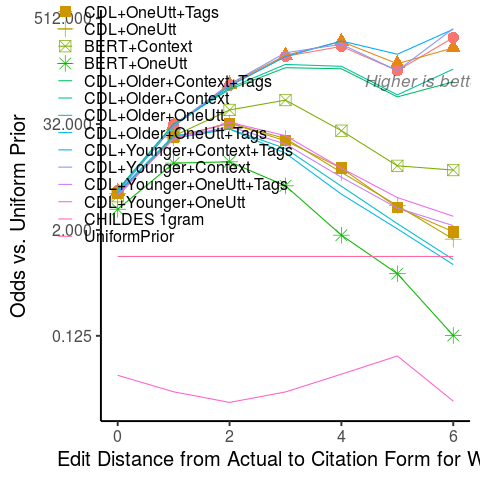

In [31]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale.pdf', height=6, width=8)    
print(p2)

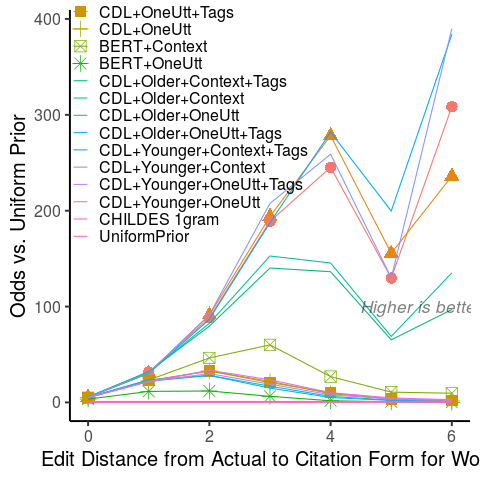

In [32]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [33]:
%%R
library(plotROC)

In [34]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 116800  41360


In [35]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

 [1] "BERT+OneUtt"              "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
 [5] "CDL+OneUtt"               "CDL+Context"             
 [7] "CDL+Younger+OneUtt+Tags"  "CDL+Younger+Context+Tags"
 [9] "CDL+Younger+OneUtt"       "CDL+Younger+Context"     
[11] "CDL+Older+OneUtt+Tags"    "CDL+Older+Context+Tags"  
[13] "CDL+Older+OneUtt"         "CDL+Older+Context"       
[15] "UniformPrior"             "CHILDES 1gram"           


In [36]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls 

In [37]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 2),')')

In [38]:
%%R
scores_across_time_short$model_with_auc[1:10]

 [1] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"
 [3] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"
 [5] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"
 [7] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"
 [9] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"


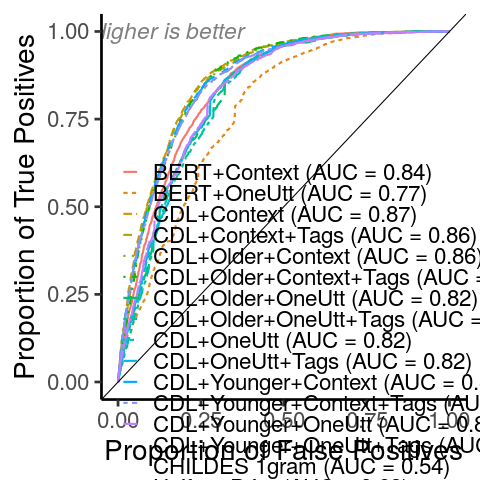

In [39]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=12, width=12)    